In [ ]:
from IPython.display import Markdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import matthews_corrcoef, average_precision_score, f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import os
original_dir = os.getcwd()
if os.path.basename(original_dir) == "SupervisedModels":
    os.chdir(os.path.dirname(original_dir))


c:\Users\Blake\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
if 'ShowOutput' in locals() or 'ShowOutput' in globals():
    ShowOutput = ShowOutput
else:
    ShowOutput = False
# Load and clean data
%run dataInfo.ipynb

score_cols = [f"A{i}_Score" for i in range(1, 11)]
train_df['total_score'] = train_df[score_cols].sum(axis=1)
test_df['total_score'] = test_df[score_cols].sum(axis=1)

# Normalize the total score
train_df['score_ratio'] = train_df['total_score'] / 10
test_df['score_ratio'] = test_df['total_score'] / 10

# Add interaction features
train_df['gender_result'] = train_df['gender'] * train_df['result']
train_df['age_score_ratio'] = train_df['age'] * train_df['score_ratio']
train_df['score_autism'] = train_df['total_score'] * train_df['autism']
train_df['age_jaundice'] = train_df['age'] * train_df['jaundice']
train_df['autism_result'] = train_df['autism'] * train_df['result']
train_df['gender_total_score'] = train_df['gender'] * train_df['total_score']

test_df['gender_result'] = test_df['gender'] * test_df['result']
test_df['age_score_ratio'] = test_df['age'] * test_df['score_ratio']
test_df['score_autism'] = test_df['total_score'] * test_df['autism']
test_df['age_jaundice'] = test_df['age'] * test_df['jaundice']
test_df['autism_result'] = test_df['autism'] * test_df['result']
test_df['gender_total_score'] = test_df['gender'] * test_df['total_score']

cleanTrain, cleanTest = train_df, test_df
X = cleanTrain.drop(columns=["Class/ASD"])
y = cleanTrain["Class/ASD"]

X_train_main, X_holdout, y_train_main, y_holdout = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:

def tune_catboost_with_cv(X, y, n_trials=30):
    smote = SMOTE(random_state=42)
    imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    def objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 100, 500),
            'depth': trial.suggest_int('depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
            'random_strength': trial.suggest_float('random_strength', 1.0, 10.0),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0),
            'random_seed': 42,
            'verbose': 0
        }

        f1_scores = []
        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            X_train = imputer.fit_transform(X_train)
            X_val = imputer.transform(X_val)
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)

            X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

            model = CatBoostClassifier(**params)
            model.fit(X_resampled, y_resampled)
            y_pred = model.predict(X_val)
            f1_scores.append(f1_score(y_val, y_pred))

        return np.mean(f1_scores)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    if(ShowOutput):
        print("Best hyperparameters:", study.best_params)
    return study.best_params


In [4]:

best_params = tune_catboost_with_cv(X_train_main, y_train_main, n_trials=40)

imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()
X_imputed = imputer.fit_transform(X_train_main)
X_scaled = scaler.fit_transform(X_imputed)
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_scaled, y_train_main)

cb_model = CatBoostClassifier(**best_params)
cb_model.fit(X_resampled, y_resampled)


Best hyperparameters: {'iterations': 146, 'depth': 4, 'learning_rate': 0.03031158256087965, 'l2_leaf_reg': 4.504335588376387, 'random_strength': 3.567011018114531, 'bagging_temperature': 0.22039854074448506, 'scale_pos_weight': 1.1687688309129962}
0:	learn: 0.6621609	total: 2.74ms	remaining: 398ms
1:	learn: 0.6342390	total: 5.24ms	remaining: 377ms
2:	learn: 0.6098468	total: 7.93ms	remaining: 378ms
3:	learn: 0.5852824	total: 10.6ms	remaining: 375ms
4:	learn: 0.5654105	total: 13.1ms	remaining: 370ms
5:	learn: 0.5452107	total: 15.7ms	remaining: 366ms
6:	learn: 0.5251344	total: 18.1ms	remaining: 359ms
7:	learn: 0.5087604	total: 20.4ms	remaining: 351ms
8:	learn: 0.4919775	total: 23.2ms	remaining: 353ms
9:	learn: 0.4784573	total: 25.7ms	remaining: 350ms
10:	learn: 0.4634348	total: 28.1ms	remaining: 345ms
11:	learn: 0.4485163	total: 30.9ms	remaining: 345ms
12:	learn: 0.4333678	total: 33.9ms	remaining: 347ms
13:	learn: 0.4246551	total: 36.7ms	remaining: 346ms
14:	learn: 0.4143983	total: 39.3ms

In [5]:
# Step 1: Copy test
X_test = cleanTest.copy()

# Step 2: Ensure all columns in training exist in test
missing_cols = set(X.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0  # or np.nan if imputer is used

# Step 3: Reorder to match training
X_test = X_test[X.columns]

imputer.fit(X_test)
scaler.fit(X_test)

# Step 4: Preprocess
X_test = imputer.transform(X_test)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Step 5: Predict
test_predictions = cb_model.predict(X_test)
test_probabilities = cb_model.predict_proba(X_test)[:, 1]

# Step 6: Store in test set
cleanTest_with_predictions = cleanTest.copy()
cleanTest_with_predictions['Class/ASD'] = test_predictions
cleanTest_with_predictions['Probability'] = test_probabilities

F1 Score: 0.7475409836065574
ROC AUC: 0.9496199881672962
Accuracy: 0.8796875
Precision: 0.6477272727272727
Recall: 0.8837209302325582


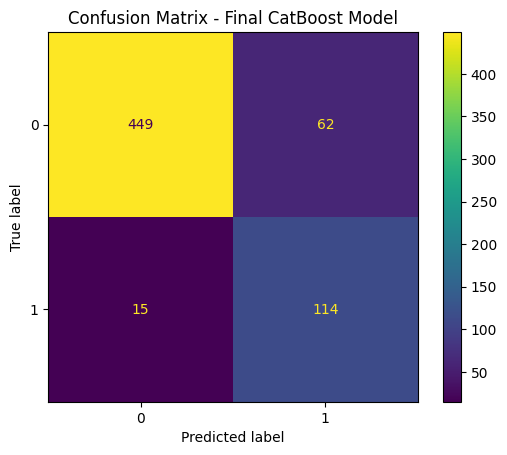

In [ ]:

y_proba = cb_model.predict_proba(X_scaled)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

final_roc_auc = roc_auc_score(y_train_main, y_pred)
final_pr_auc = average_precision_score(y_train_main, y_pred)
final_f1 = f1_score(y_train_main, y_pred)
final_mcc = matthews_corrcoef(y_train_main, y_pred)
accuracy = accuracy_score(y_train_main, y_pred)

if(ShowOutput):
    # print("F1 Score:", f1_score(y_train_main, y_pred))
    # print("ROC AUC:", roc_auc_score(y_train_main, y_proba))
    # print("Accuracy:", accuracy_score(y_train_main, y_pred))
    # print("Precision:", precision_score(y_train_main, y_pred))
    # print("Recall:", recall_score(y_train_main, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_train_main, y_pred)
    plt.title("Confusion Matrix - Final CatBoost Model")
    plt.show()
    
    df_metrics = pd.DataFrame({
        "Metric": ["ROC AUC", "PR AUC", "F1 Score", "Matthews Corrcoef", "Accuracy"],
        "Value": [final_roc_auc, final_pr_auc, final_f1, final_mcc, accuracy]
    })

    df_metrics["Value"] = df_metrics["Value"].map("{:.4f}".format)

    display(df_metrics)
